In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:02<00:00, 12251631.43it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207932.12it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3870280.11it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22123234.62it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
# sample tensor from the data

img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [3]:
# Function to denormalize the images
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


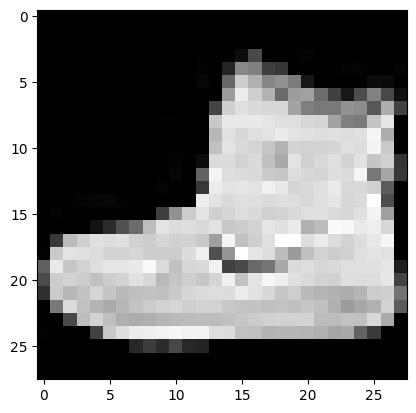

In [7]:
# Showing the Image
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [8]:
from torch.utils.data import DataLoader
batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([2, 7, 9, 3, 9, 7, 1, 6, 5, 5, 3, 3, 3, 4, 6, 1, 4, 6, 1, 6, 6, 7, 3, 7,
        0, 7, 5, 1, 3, 8, 9, 6, 0, 2, 1, 6, 8, 0, 7, 9, 9, 4, 0, 5, 8, 8, 1, 4,
        5, 6, 3, 3, 3, 5, 7, 7, 6, 7, 4, 9, 5, 3, 8, 8, 7, 5, 9, 0, 1, 4, 8, 3,
        3, 2, 0, 5, 6, 4, 6, 0, 0, 4, 6, 8, 7, 8, 5, 5, 7, 0, 6, 1, 2, 0, 1, 9,
        5, 0, 0, 3])


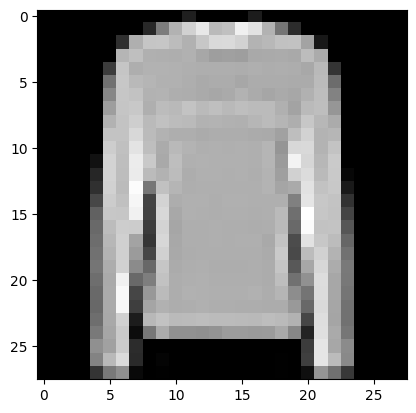

In [9]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
image_size = 784
hidden_size = 256

In [12]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [13]:
D.to(device);

In [14]:
latent_size = 64

In [15]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [16]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

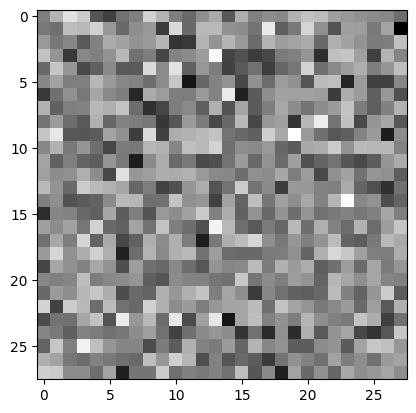

In [17]:
plt.imshow(gen_imgs[0], cmap='gray');

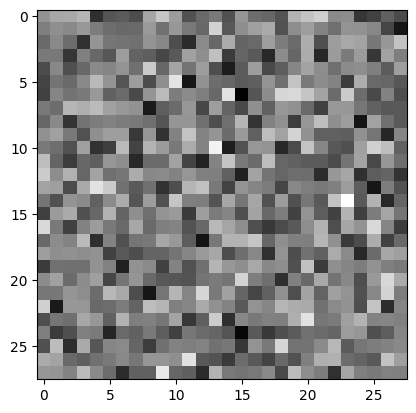

In [18]:
plt.imshow(gen_imgs[1], cmap='gray');

In [19]:
# moving the generator to the chosen device.
G.to(device);

In [20]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [21]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [22]:
def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for the real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for the fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine the losses
    d_loss = d_loss_real + d_loss_fake
    # Reset the gradients
    reset_grad()
    # Compute the gradients
    d_loss.backward()
    # Adjust the parameters using the backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [23]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [24]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [26]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

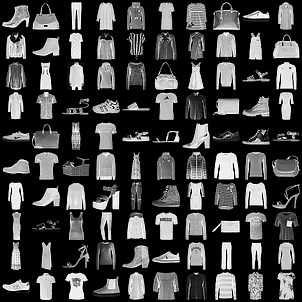

In [27]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some of the real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


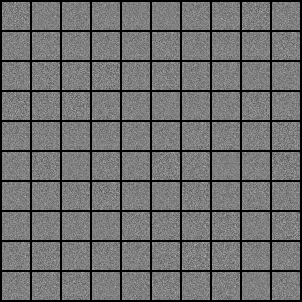

In [28]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [30]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.0104, g_loss: 0.9212, D(x): 0.97, D(G(z)): 0.07
Epoch [0/50], Step [400/600], d_loss: 0.0152, g_loss: 0.9634, D(x): 0.97, D(G(z)): 0.06
Epoch [0/50], Step [600/600], d_loss: 0.0153, g_loss: 0.9801, D(x): 0.97, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.0028, g_loss: 0.9506, D(x): 0.98, D(G(z)): 0.02
Epoch [1/50], Step [400/600], d_loss: 0.0020, g_loss: 0.9742, D(x): 0.99, D(G(z)): 0.01
Epoch [1/50], Step [600/600], d_loss: 0.0029, g_loss: 0.9911, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.0162, g_loss: 0.9529, D(x): 0.98, D(G(z)): 0.03
Epoch [2/50], Step [400/600], d_loss: 0.0017, g_loss: 0.9727, D(x): 1.00, D(G(z)): 0.01
Epoch [2/50], Step [600/600], d_loss: 0.0035, g_loss: 0.9881, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.0139, g_loss: 0.9547, D(x): 0.98, D(G(z)): 0.05
Epoch [3/50], Step [400/600], d_loss

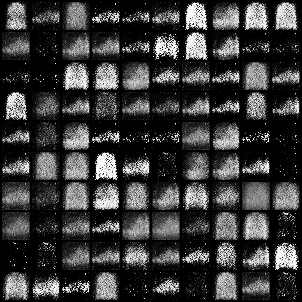

In [31]:
Image('./samples/fake_images-0010.png')

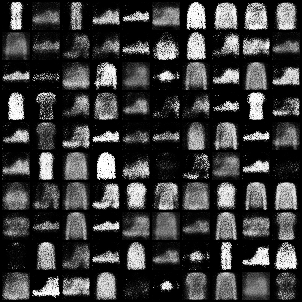

In [32]:
Image('./samples/fake_images-0024.png')

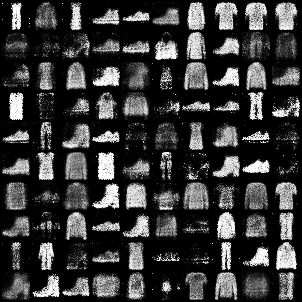

In [33]:
Image('./samples/fake_images-0050.png')

In [35]:
torch.save(G.state_dict(), 'model_generator.pth')
torch.save(D.state_dict(), 'model_discriminator.pth')

In [36]:
G.load_state_dict(torch.load('model_generator.pth'))
D.load_state_dict(torch.load('model_discriminator.pth'))

<All keys matched successfully>

In [37]:
%%time

num_additional_epochs = 50  # number of epochs to train
start_epoch = 50
end_epoch = start_epoch + num_additional_epochs
total_num_epoch = end_epoch

total_step = len(data_loader)
for epoch in range(start_epoch, end_epoch):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Training of discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspection of  the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, total_num_epoch, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [50/100], Step [200/600], d_loss: 0.3758, g_loss: 0.6378, D(x): 0.66, D(G(z)): 0.29
Epoch [50/100], Step [400/600], d_loss: 0.2996, g_loss: 0.6809, D(x): 0.71, D(G(z)): 0.29
Epoch [50/100], Step [600/600], d_loss: 0.2154, g_loss: 0.6584, D(x): 0.76, D(G(z)): 0.22
Saving fake_images-0051.png
Epoch [51/100], Step [200/600], d_loss: 0.3261, g_loss: 0.7591, D(x): 0.67, D(G(z)): 0.27
Epoch [51/100], Step [400/600], d_loss: 0.2406, g_loss: 0.7189, D(x): 0.72, D(G(z)): 0.24
Epoch [51/100], Step [600/600], d_loss: 0.2543, g_loss: 0.6183, D(x): 0.78, D(G(z)): 0.27
Saving fake_images-0052.png
Epoch [52/100], Step [200/600], d_loss: 0.2660, g_loss: 0.7565, D(x): 0.70, D(G(z)): 0.19
Epoch [52/100], Step [400/600], d_loss: 0.2598, g_loss: 0.6842, D(x): 0.76, D(G(z)): 0.30
Epoch [52/100], Step [600/600], d_loss: 0.2243, g_loss: 0.6742, D(x): 0.73, D(G(z)): 0.17
Saving fake_images-0053.png
Epoch [53/100], Step [200/600], d_loss: 0.2070, g_loss: 0.7312, D(x): 0.81, D(G(z)): 0.24
Epoch [53/100], 

In [38]:
torch.save(G.state_dict(), 'retrained_generator.pth')
torch.save(D.state_dict(), 'retrained_discriminator.pth')

In [39]:
G.load_state_dict(torch.load('retrained_generator.pth'))
D.load_state_dict(torch.load('retrained_discriminator.pth'))

<All keys matched successfully>

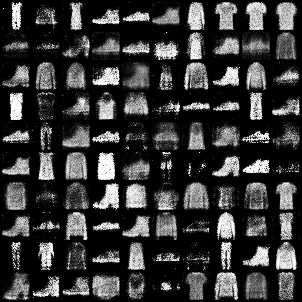

In [40]:
Image('./samples/fake_images-0056.png')

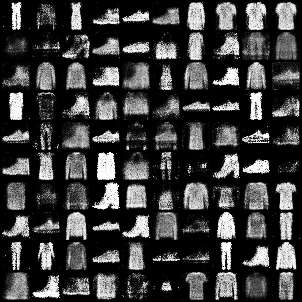

In [41]:
Image('./samples/fake_images-0064.png')

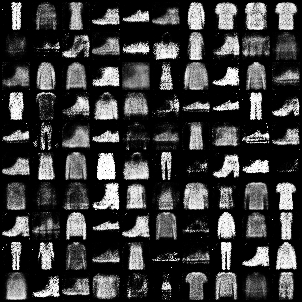

In [42]:
Image('./samples/fake_images-0070.png')

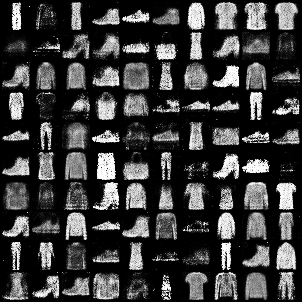

In [43]:
Image('./samples/fake_images-0086.png')

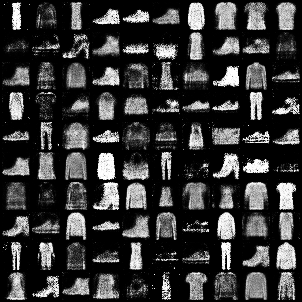

In [44]:
Image('./samples/fake_images-0093.png')

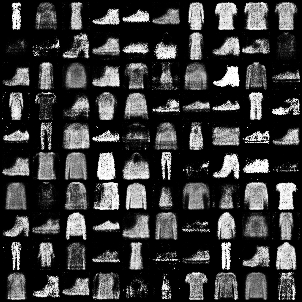

In [45]:
Image('./samples/fake_images-0100.png')

Losses of Discriminator and Generator

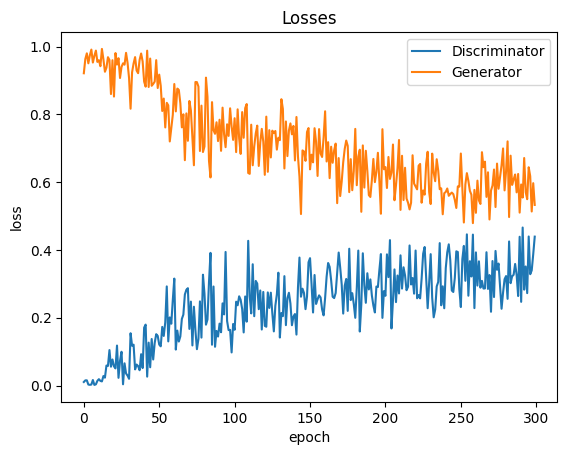

In [46]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Real Score Vs Fake Score¶

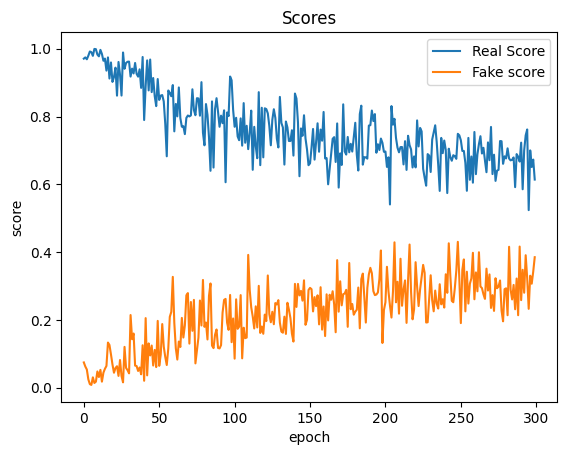

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

The GAN and LSGAN graphs exhibit stark contrasts in training stability. GAN's discriminator quickly outperforms its generator, leading to fluctuating generator loss. In contrast, LSGAN maintains a more balanced loss, suggesting a stable learning environment. LSGAN's fake scores also improve steadily, indicating a generator that consistently learns to create convincing images, unlike GAN's generator which struggles to keep up. This comparative stability in LSGAN can lead to higher quality image generation.